mainly looking at https://github.com/ngessert/isic2019/blob/master/models.py

# start

In [1]:
class Param: pass
param = Param()

param.PRFX = 'Mel0627A2'
param.PRFX_PREP = 'MelPrp0626A2'
param.ARCH = 'efficientnet-b1'
param.SZ = 224
param.EPOCHS = 10
param.BS = 128
param.K=5; param.SEED=101; param.FLD2USE=0
param.FP16 = True

param.LR=3e-4
param.WD=0.

param.N_SAMPL = int(2e3)

param.DEBUG = False
if param.DEBUG: 
    param.EPOCHS=2
    param.K = 2
    param.N_SAMPL = 1024

DEVICE = 'cuda'; PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4



In [2]:
param.__dict__

{'PRFX': 'Mel0627A2',
 'PRFX_PREP': 'MelPrp0626A2',
 'ARCH': 'efficientnet-b1',
 'SZ': 224,
 'EPOCHS': 2,
 'BS': 128,
 'K': 2,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'LR': 0.0003,
 'WD': 0.0,
 'N_SAMPL': 1024,
 'DEBUG': True}

In [3]:
!nvidia-smi

Sat Jun 27 15:47:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   63C    P0    70W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [4]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet

from apex import amp

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out=f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
# p_cmp = '../input/siim-isic-melanoma-classification'



# prep

In [5]:
# train,test,sample_submission = (pd.read_csv(o, nrows=100 if DEBUG else None) 
#                                 for o in [f'{p_cmp}/{o}.csv' 
#                                           for o in ('train', 'test', 'sample_submission')])
# print([o.shape for o in (train,test,sample_submission)])
# display(test.head(2))
# p_19 = '../input/andrewmvd--isic-2019'

p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58457, 4)


,source,im_pth,patient_id,target
24437,20,../input/siim-isic-melanoma-classification/jpe...,IP_4021847,0.0
57432,19,../input/andrewmvd--isic-2019/ISIC_2019_Traini...,BCN_0004730,1.0


(1024, 4)

20    553
19    471
Name: source, dtype: int64

source
19    0.205945
20    0.018083
Name: target, dtype: float64

## folds

In [6]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

43


In [7]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl={fld:(tr,vl) for fld,(tr,vl) in enumerate(kf.split(dftrn, groups=dftrn.patient_id))}

for fld, (tr, vl) in fld2trvl.items():
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())


0 512 512
1 512 512


0.0    0.898438
1.0    0.101562
Name: target, dtype: float64

0.0    0.892578
1.0    0.107422
Name: target, dtype: float64

20    272
19    240
Name: source, dtype: int64

20    281
19    231
Name: source, dtype: int64

## load images

In [8]:
# ims_pil = []
# for im_pth in tqdm(dftrn.im_pth):
#     ims_pil.append(Image.open(im_pth))
### faster to preload images
# i = np.random.choice(range(len(dftrn)))
# %%timeit 
# im_pil = Image.open(dftrn.im_pth.values[i])
# %%timeit 
# im_pil = ims_pil[i]

# dataset

In [9]:
class MelDataset(Dataset):
    def __init__(self, df, istrn=True):
        self.df = df
        self.istrn = istrn
        self.composed = transforms.Compose([
            transforms.RandomResizedCrop(param.SZ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])    
    def __getitem__(self, i):
        x = Image.open(self.df.im_pth.values[i]) #self.imgs[i]
        x = self.composed(x)
        if self.istrn:
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [10]:
# ds_trn = MelDataset(dftrn)
# ds_trn[0][0].shape, ds_trn[0][1]

# plt.imshow(ds_trn[0][0].numpy().transpose(1,2,0));
# plt.show()

# dl_trn = DataLoader(ds_trn, batch_size=param.BS, shuffle=True, num_workers=N_WORKERS, pin_memory=PIN_MEM)
# for dat in dl_trn:
#     x,y=dat; break

# print(x.shape, y)

# del ds_trn; gc.collect()

# model

In [11]:
# mdl = EfficientNet.from_pretrained(ARCH, num_classes=1)
# mdl(x).shape

# train

In [12]:
tr,vl=fld2trvl[param.FLD2USE]
dftr=dftrn.iloc[tr]
dfvl=dftrn.iloc[vl]
ystr=dftr.target.values
ysvl=dfvl.target.values
print(len(dftr), len(dfvl))
dstr = MelDataset(dftr)
dsvl = MelDataset(dfvl)
print(len(dstr), len(dsvl))
dltr = DataLoader(dstr, batch_size=param.BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
dlvl = DataLoader(dsvl, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltr), len(dlvl))
lendl=len(dltr)

512 512
512 512
4 2


In [13]:
def evaluate(ys, model, dl):
    with torch.no_grad():
        model.eval()
        prd = []
        for step, batch in enumerate(dl):
            xb, yb=(o.to(device) for o in batch)
            prdb = model(xb)
            prd.append(prdb.cpu().detach().numpy())
        prd = np.concatenate(prd)    
        lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(ys).unsqueeze(1)).item()
        scr = roc_auc(ys, prd)
    return lss, scr, ys, prd

In [14]:
mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
mdl = mdl.to(device)

# opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
# schdl = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=PLTFACTOR, patience=PATIENCE, min_lr=MIN_LR, verbose=True)

mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
mdl.zero_grad()


Loaded pretrained weights for efficientnet-b1


## run train

In [15]:
stats = {
    'lss': {'tr':[],'vl':[]},
    'scr': {'tr':[],'vl':[]},
}
oof = {'y':[], 'prd':[]}
best_scr = float('-inf')
best_epc = -1
for epc in range(param.EPOCHS):
    prdtr_ep=[]
    ytr_ep=[]
    for step, dat in enumerate(dltr):
        mdl.train()
        xb,yb=(o.to(device) for o in dat)
        yb=yb.unsqueeze(1)
        prdb = mdl(xb)
        loss = F.binary_cross_entropy_with_logits(prdb, yb)
        if param.FP16:
            with amp.scale_loss(loss, opt) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        if param.FP16:
            torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
        else:
            torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
        opt.step()
        opt.zero_grad()
        prdtr_ep.append(prdb.cpu().detach().numpy())
        ytr_ep.append(yb.cpu().detach().numpy())
        if step%1000==0: 
            print(dtnow(), f'ep {epc} step {step}/{lendl}')
    
    prdtr_ep = np.concatenate(prdtr_ep)
    ytr_ep = np.concatenate(ytr_ep)    
    lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
    scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
    stats['lss']['tr'].append(lss_tr_ep)
    stats['scr']['tr'].append(scr_tr_ep)
    
    lss_vl_ep, scr_vl_ep, y_vl_ep, prd_vl_ep = evaluate(ysvl, mdl, dlvl)
    stats['lss']['vl'].append(lss_vl_ep)
    stats['scr']['vl'].append(scr_vl_ep)
    oof['y'].append(y_vl_ep)
    oof['prd'].append(prd_vl_ep)
    
    print(dtnow(), f'ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')
    
    if scr_vl_ep>best_scr:
        print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
        best_scr = scr_vl_ep
        best_epc = epc
        if not param.DEBUG: torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
    if not param.DEBUG: torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')
        
#     schdl.step(lossval)  # Update learning rate schedule
        
    

2020-06-27 15:48:13 ep 0 step 0/4
2020-06-27 15:50:02 ep 0: lss_tr 0.643; lss_vl 0.817; scr_tr 0.550; scr_vl 0.375; 
better scr -inf -> 0.375
2020-06-27 15:51:03 ep 1 step 0/4
2020-06-27 15:52:49 ep 1: lss_tr 0.496; lss_vl 0.685; scr_tr 0.672; scr_vl 0.462; 
better scr 0.375 -> 0.462


## run done

In [16]:
print(f'best_scr {best_scr:.4f}')

best_scr 0.4619


In [17]:
pd.DataFrame(stats['lss'])

,tr,vl
0,0.642549,0.817334
1,0.496344,0.685338


In [18]:
pd.DataFrame(stats['scr'])

,tr,vl
0,0.550293,0.375433
1,0.672471,0.461866


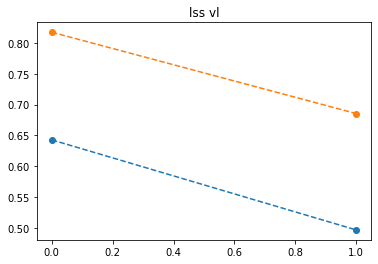

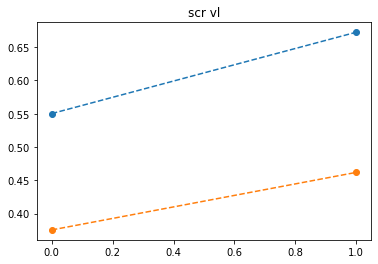

In [19]:
for k,v in stats.items():
    for tv,vs in v.items():
        plt.title(f'{k} {tv}')
        plt.plot(vs, 'o--')
    plt.show()

In [20]:
stats['best_scr'] = best_scr
stats['best_epc'] = best_epc

results = {}
results['fld2trvl'] = fld2trvl
results['oof'] = oof
results['stats'] = stats

pickle.dump(results, open(f'{p_out}/results.p', 'wb'))

In [21]:
pickle.dump(param, open(f'{p_out}/param.p', 'wb'))

# fin

In [22]:
print(f'best_scr {best_scr:.4f}')

best_scr 0.4619


In [23]:
param.__dict__

{'PRFX': 'Mel0627A2',
 'PRFX_PREP': 'MelPrp0626A2',
 'ARCH': 'efficientnet-b1',
 'SZ': 224,
 'EPOCHS': 2,
 'BS': 128,
 'K': 2,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'LR': 0.0003,
 'WD': 0.0,
 'N_SAMPL': 1024,
 'DEBUG': True}

In [24]:
!nvidia-smi

Sat Jun 27 15:52:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   61C    P0    66W / 149W |  10068MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  